### Audio Classification 

1. Importing the dataset from kaggle using API

In [1]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!kaggle datasets download -d chrisfilo/urbansound8k

urbansound8k.zip: Skipping, found more recently modified local copy (use --force to force download)


2. Unzip the Dataset:

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/urbansound8k.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

3.Importing the important libaries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense,GlobalAveragePooling2D, Dropout

Extra: Read a sample audio using librosa

In [5]:
audio_file_path='/content/fold7/104625-4-0-51.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [6]:
print(f"librosa_audio_data: {librosa_audio_data},librosa_sample_rate: {librosa_sample_rate}")

librosa_audio_data: [ 0.0153159   0.01311499  0.01057386 ... -0.00617195 -0.01938896
 -0.0366668 ],librosa_sample_rate: 22050


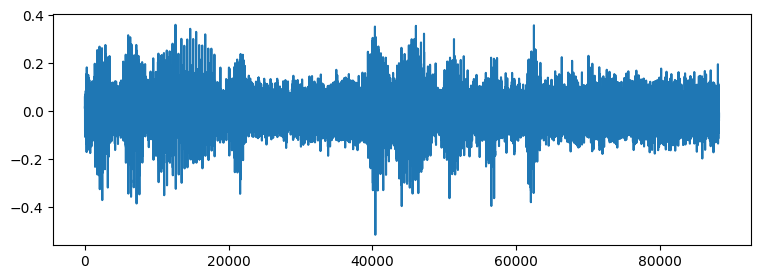

In [7]:
plt.figure(figsize=(9, 3))
plt.plot(librosa_audio_data);

In [8]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


4. Import the csv file having all file name and other details

In [9]:
#audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('/content/UrbanSound8K.csv')
metadata.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [10]:
metadata['file_path'] = '/content/'+'fold'+metadata.fold.astype(str)+'/'+metadata['slice_file_name']
metadata.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class                          file_path  
0          dog_bark    /content/fold5/100032-3-0-0.wav  
1  children_playing  /content/fold5/100263-2-0-117.wav  
2  children_playing  /content/fold5/100263-2-0-121.wav  
3  children_playing  /content/fold5/100263-2-0-126.wav  
4  children_playing  /content/fold5/100263-2-0-137.wav

5. Data visulization- Plot the graphs for class with their counts

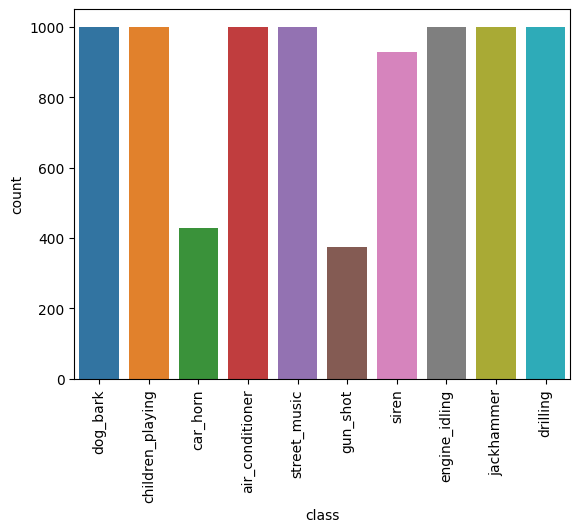

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [11]:
sns.countplot(x='class', data=metadata)
plt.xticks(rotation=90);
plt.show()
metadata['class'].value_counts()

6. Iterate through every audio file and extract features using Mel-Frequency Cepstral Coefficients

In [12]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='scipy')  # you can prefer res_type ='kaiser_fast'
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [13]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = str(row['file_path'])
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [02:04, 31.44it/s]/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8324it [04:53, 41.10it/s]/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [05:06, 28.46it/s]


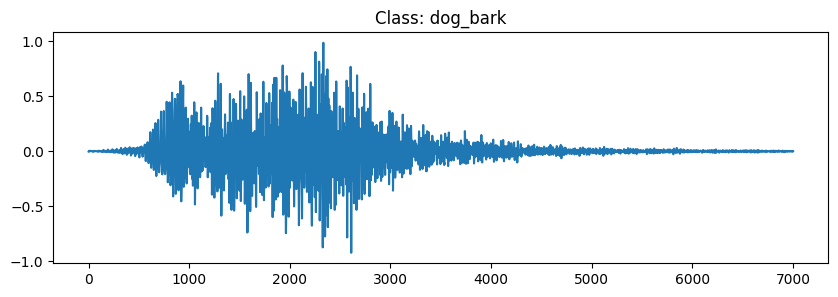

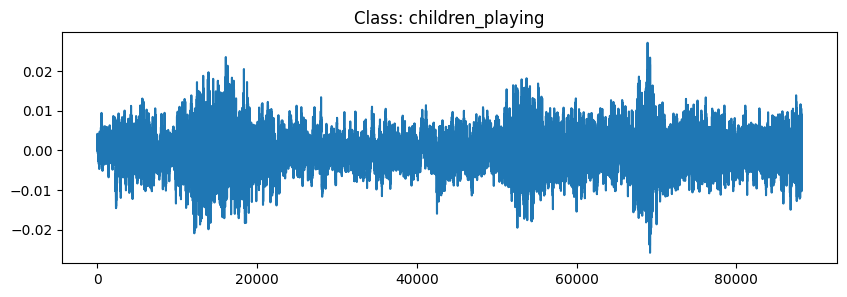

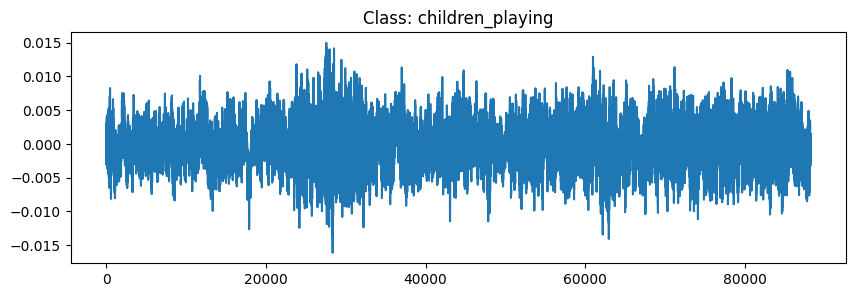

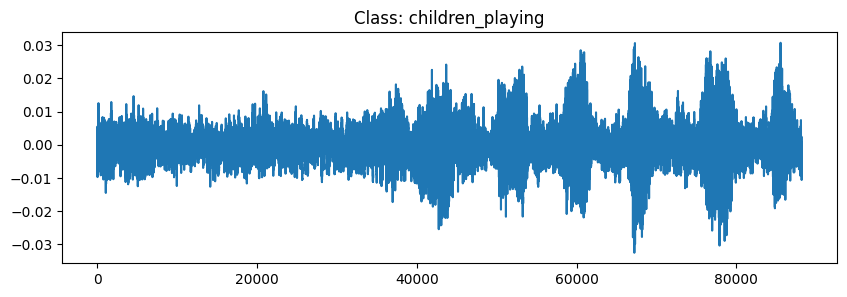

In [14]:
for i in range(4):
    x, sr = librosa.load(metadata.file_path[i])
    plt.figure(figsize=(10,3))
    plt.title('Class: '+str(metadata['class'][i]))
    plt.plot(x);

7. Converting extracted_features to Pandas dataframe

In [15]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

feature             class
0  [-211.01833, 61.279896, -121.51646, -62.041412...          dog_bark
1  [-415.5431, 97.27048, -40.93115, 49.012505, 11...  children_playing
2  [-450.981, 110.367256, -35.585976, 41.206604, ...  children_playing
3  [-405.06644, 89.19861, -23.047182, 40.789795, ...  children_playing
4  [-438.15137, 101.76034, -40.557262, 48.588905,...  children_playing

8. Split the dataset into independent and dependent dataset

In [16]:
#Converting to array

X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [17]:
X.shape

(8732, 40)

In [18]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [19]:
### Label Encoding for dependent feature
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [20]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [22]:
X_train

array([[-1.07915062e+02,  1.49111191e+02, -1.69931202e+01, ...,
        -2.02407951e+01, -4.37700891e+00,  1.76457310e+01],
       [-4.75300446e+02,  1.36014557e+02, -1.66016254e+01, ...,
        -1.55108058e+00, -3.40763783e+00, -2.35980582e+00],
       [-1.49834305e+02,  2.86153030e+01, -2.16736145e+01, ...,
        -2.82404780e+00,  5.40655661e+00,  5.66880226e+00],
       ...,
       [-6.50193100e+01,  1.08286835e+02,  3.81065140e+01, ...,
         2.33698249e+00, -6.12008989e-01,  3.85089564e+00],
       [-7.13185791e+02,  1.51895737e+02,  3.57981873e+01, ...,
        -1.88972712e+00, -1.45986211e+00, -1.49277616e+00],
       [-9.45731544e+00,  8.08291168e+01, -1.60781765e+01, ...,
        -4.59818602e+00, -3.15645170e+00, -6.94729209e-01]], dtype=float32)

In [23]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
X_train.shape

(6985, 40)

In [25]:
X_test.shape

(1747, 40)

In [26]:
y_train.shape

(6985, 10)

In [27]:
y_test.shape

(1747, 10)

9. Model Creation

In [28]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [30]:
### No of classes
num_labels=y.shape[1]

In [31]:
num_labels

10

In [32]:
model=Sequential()
###first layer
model.add(Dense(500,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###second layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               20500     
                                                                 
 activation (Activation)     (None, 500)               0         
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 activation_1 (Activation)   (None, 300)               0         
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               3

In [34]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [35]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
210/219 [===========================>..] - ETA: 0s - loss: 6.1009 - accuracy: 0.1140
Epoch 1: val_loss improved from inf to 2.28623, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 8s 6ms/step - loss: 5.9612 - accuracy: 0.1134 - val_loss: 2.2862 - val_accuracy: 0.1162
Epoch 2/100
216/219 [============================>.] - ETA: 0s - loss: 2.3598 - accuracy: 0.1172
Epoch 2: val_loss improved from 2.28623 to 2.25079, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 5ms/step - loss: 2.3589 - accuracy: 0.1173 - val_loss: 2.2508 - val_accuracy: 0.1351
Epoch 3/100
206/219 [===========================>..] - ETA: 0s - loss: 2.2652 - accuracy: 0.1356
Epoch 3: val_loss improved from 2.25079 to 2.22151, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.2646 - accuracy: 0.1357 - val_loss: 2.2215 - val_accuracy: 0.1442

10. Checking & Evaluating the model

In [36]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8609043955802917


In [37]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.920400857925415
Testing Accuracy:  0.8609043955802917


In [38]:
def prediction_(filename):
  audio, sample_rate = librosa.load(filename, res_type='scipy') 
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
  #print(mfccs_scaled_features)
  mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
  #print(mfccs_scaled_features)
  #print(mfccs_scaled_features.shape)
  predicted_ = model.predict(mfccs_scaled_features)
  predicted_label = np.argmax(predicted_,axis=1)
  pred_class = labelencoder.inverse_transform(predicted_label)
  print("The predicted class is: ", pred_class[0])

In [39]:
filename = '/content/fold10/100795-3-1-0.wav'
prediction_(filename) 
print("\n")
print(f"verify the prediction by listening the sound:")
ipd.Audio(filename)


1/1 [==============================] - 0s 115ms/step
The predicted class is:  dog_bark


verify the prediction by listening the sound:


In [40]:
filename = '/content/fold5/100852-0-0-2.wav'
prediction_(filename) 
print("\n")
print(f"verify the prediction by listening the sound:")
ipd.Audio(filename)

1/1 [==============================] - 0s 29ms/step
The predicted class is:  air_conditioner


verify the prediction by listening the sound:


In [41]:
filename = '/content/fold7/104625-4-0-53.wav'
prediction_(filename) 
print("\n")
print(f"verify the prediction by listening the sound:")
ipd.Audio(filename)

1/1 [==============================] - 0s 40ms/step
The predicted class is:  drilling


verify the prediction by listening the sound:
